In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
%matplotlib inline

## 1.1 Compute Best K

### 1.1.1 Data Preprocessing

In [11]:
import gzip

image_size = 28
num_train = 50000
num_test = 10000

# read in training data
# images
f = gzip.open('train-images-idx3-ubyte.gz','r')
f.read(16)
buf = f.read(image_size * image_size * num_train)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
X_train = data.reshape(num_train, -1)
# labels
f = gzip.open('train-labels-idx1-ubyte.gz','r')
f.read(8)
buf = f.read(num_train)
y_train = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)

# read in testing data
# images
f = gzip.open('t10k-images-idx3-ubyte.gz','r')
f.read(16)
buf = f.read(image_size * image_size * num_test)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
X_test = data.reshape(num_test, -1)
# labels
f = gzip.open('t10k-labels-idx1-ubyte.gz','r')
f.read(8)
buf = f.read(num_test)
y_test = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)

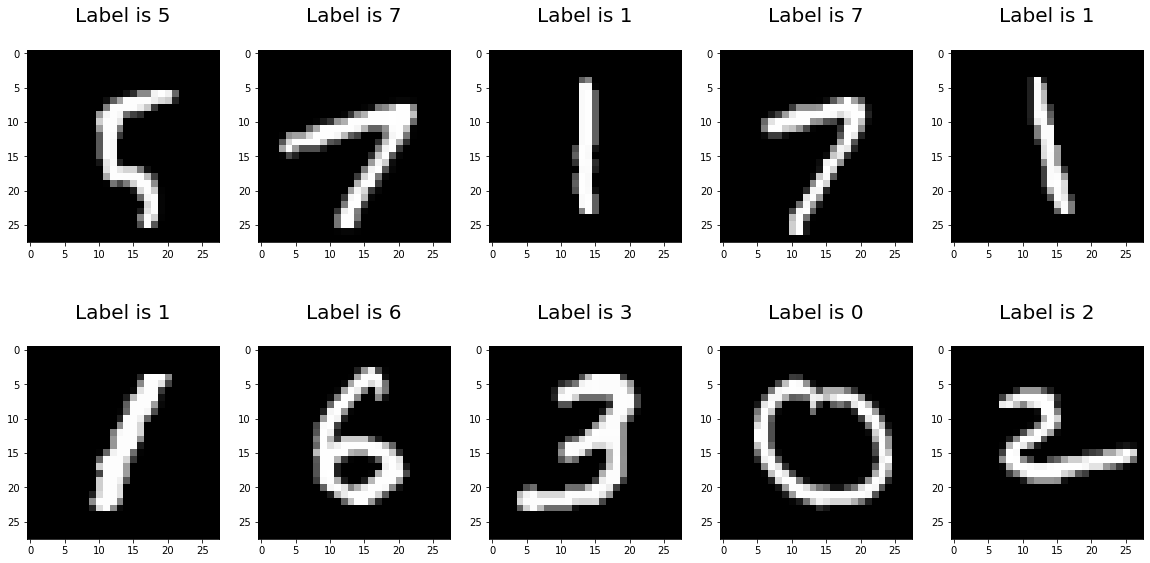

In [12]:
plt.figure(figsize=(20,10))
for index, (image, label) in enumerate(zip(X_train[100:110], y_train[100:110])):
    plt.subplot(2, 5, index + 1)
    plt.imshow(image.reshape([28, 28])*255, cmap=plt.cm.gray) # we multiply 255 for de-normalization
    plt.title('Label is %i\n' % label, fontsize = 20)

### 1.1.2 KNN implementation

In [13]:
import numpy as np
import multiprocessing
from functools import partial
from contextlib import contextmanager

@contextmanager
def poolcontext(*args, **kwargs):
    pool = multiprocessing.Pool(*args, **kwargs)
    yield pool
    pool.terminate()

# this is the worker
def single_prediction(i, X, y, x, K=1, p=2, DEBUG = False):
    '''
        Inputs:
            i: current index
            X: A matrix of size N x F, which stores all the training data
            y: A vector of size N, which stores all the training labels
            x: A matrix of size M x F, which is the data we want to predict
            K: Number of Nearest Neighbour
            p: The power for distance metric
        Output:
            res: Predicted class
    '''
    # dist is vector of size N 
    dist = np.power( np.sum( np.power( np.abs( X-x[i] ), p), axis=1 ), 1./p)
    # dist_mask is of size K
    dist_mask = dist.argsort()[:K]
    # labels is of size K
    labels = y[dist_mask]
    if DEBUG:
        print(dist, dist_mask, labels)
    return np.bincount(labels).argmax()

In [14]:
def kNNPredict(X, y, x, K=1, p=2, DEBUG = False):
    '''
        Inputs:
            X: A matrix of size N x F, which stores all the training data

        Output:
            res: A matrix of size M x N, whose ith row stores the distance vector for x[i] 
    '''
    M = len(x)
    if __name__ == '__main__':
        with poolcontext(processes=16) as pool:
            res = pool.map(partial(single_prediction, X=X, y=y, x=x, K=K, p=p, DEBUG = DEBUG), range(M))
    return res

In [15]:
def kNNTrain(X, y, X_val, y_val, K=1, p=2):
    '''
        kNNTrain will help finding the optimal K
        Inputs:
            X: Training features of size N x F
            y: Training labels of size N
            X_val: Validation features of size M x F
            y_val: Validation labels of size M
            K: The number of neighbours
        Output:
            res: Accurancy for validation set
    '''
    predictions = kNNPredict(X, y, X_val, K=K, p=p)
    return np.float(np.sum(predictions == y_val)) / len(y_val)

In [16]:
a = np.array([[1,2,3,4],[2,3,4,5],[3,4,5,6],[4,5,6,7]])
b = np.array([1,1,2,3])
c = np.array([[1,1,1,4],[3,4,2,6],[2,3,4,5]])
kNNPredict(a,b,c, DEBUG=True)
kNNPredict(a,b,c, K=2, DEBUG=True)

[2.23606798 3.87298335 5.74456265 7.68114575] [0] [1]
[2. 0. 2. 4.] [1] [1]
[3.60555128 2.64575131 3.         4.35889894] [1] [1]
[3.60555128 2.64575131 3.         4.35889894] [1 2] [1 2]
[2.23606798 3.87298335 5.74456265 7.68114575] [0 1] [1 1]
[2. 0. 2. 4.] [1 0] [1 1]


[1, 1, 1]

### 1.1.3 KNN Training

In [17]:
# 10-fold cross validation
permutation = np.random.permutation(num_train)
X_train, y_train = X_train[permutation], y_train[permutation]
Ks = np.array([1,2,3,4,5,10,20,50,100,500])

In [18]:
########################## This cell won't be excecuted for reason below ##############################
%%perl -eat

Accuracies = []
for k in Ks:
    accuracy = []
    step = int(num_train/10)
    for fold in range(0, num_train, step):
        mask = np.array([False] * num_train)
        mask[fold:fold+step] = True
        X = X_train[~mask]
        y = y_train[~mask]
        X_val = X_train[mask]
        y_val = y_train[mask]

        start_time = time.time()
        score = kNNTrain(X, y, X_val, y_val, K=k)
        elapsed_time = time.time() - start_time
        print("k=%d, accuracy=%.2f%%, time=%.2f" % (k, score*100, elapsed_time))
        accuracy.append(score)
    Accuracies.append(accuracy)

Accuracies = np.array(Accuracies)
np.savetxt("results.csv", Accuracies, delimiter=",")

UsageError: Line magic function `%%perl` not found.


## <span style="color:red">Important Note: </span>
### <span style="color:red">Jupyter Notebook has VERY bad support for multiprocessing. Thus, I wrote a python script (kNN.py) that wraps everything above and we will run the script directly.</span>

In [1]:
!python kNNTrain.py

k=1, accuracy=97.42%, time=364.88
k=1, accuracy=97.06%, time=415.88
k=1, accuracy=97.20%, time=431.47
k=1, accuracy=96.94%, time=408.49
k=1, accuracy=97.00%, time=418.45
k=1, accuracy=97.22%, time=407.43
k=1, accuracy=96.82%, time=458.05
k=1, accuracy=97.72%, time=454.65
k=1, accuracy=96.72%, time=458.72
k=1, accuracy=97.10%, time=458.76
k=2, accuracy=96.72%, time=459.92
k=2, accuracy=96.32%, time=467.15
k=2, accuracy=96.38%, time=495.89
k=2, accuracy=96.60%, time=455.83
k=2, accuracy=96.48%, time=421.48
k=2, accuracy=96.36%, time=417.23
k=2, accuracy=96.36%, time=427.40
k=2, accuracy=96.98%, time=417.88
k=2, accuracy=95.68%, time=448.57
k=2, accuracy=96.40%, time=402.80
k=3, accuracy=97.28%, time=453.55
k=3, accuracy=97.08%, time=398.50
k=3, accuracy=97.00%, time=455.82
k=3, accuracy=97.12%, time=391.70
k=3, accuracy=97.34%, time=400.11
k=3, accuracy=97.02%, time=384.79
k=3, accuracy=96.78%, time=452.54
k=3, accuracy=97.66%, time=407.01
k=3, accuracy=96.42%, time=434.09
k=3, accuracy=

In [19]:
# retrive the accurancy history
import csv

Accuracies = []
with open('results.csv') as csv_file:
    csv_reader = csv.reader(csv_file)
    count = 0
    for row in csv_reader:
        Accuracies.append(np.asarray(row, dtype=np.float))
        count += 1
    print(f'Processed {count} lines.')

Processed 10 lines.


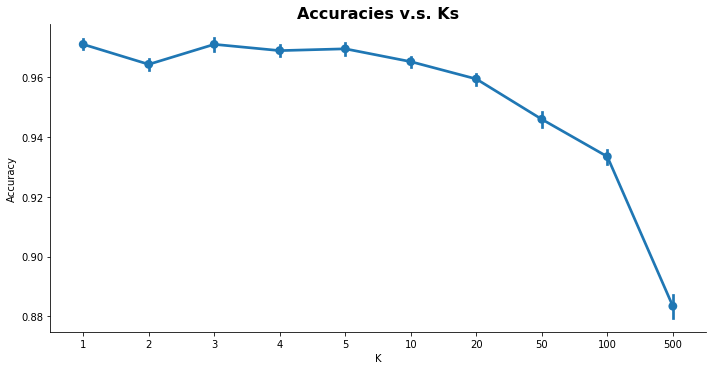

In [20]:
import pandas as pd
import seaborn as sns

data = pd.DataFrame({'K': np.repeat(Ks, 10), 'Accuracy': np.array(Accuracies).reshape(-1)})

sns.catplot(x='K', y='Accuracy',  kind="point", data=data, aspect=2)
plt.title('Accuracies v.s. Ks', weight='bold', fontsize=16)
plt.show()

## Notice that the accurancies begin to drop dramatically after K=10 and it seems that it's possible the optimal K occurs between 5 to 10. So we will rerun our script for K=6, 7, 8, 9.

In [39]:
!python kNNTrain2.py

k=6, accuracy=96.76%, time=416.36
k=6, accuracy=96.60%, time=460.41
k=6, accuracy=96.86%, time=437.56
k=6, accuracy=96.34%, time=410.28
k=6, accuracy=97.14%, time=409.41
k=6, accuracy=97.20%, time=411.18
k=6, accuracy=97.00%, time=408.02
k=6, accuracy=96.94%, time=409.02
k=6, accuracy=96.58%, time=408.99
k=6, accuracy=96.96%, time=407.30
k=7, accuracy=96.64%, time=407.96
k=7, accuracy=96.72%, time=407.30
k=7, accuracy=96.74%, time=471.73
k=7, accuracy=96.42%, time=473.08
k=7, accuracy=97.04%, time=475.83
k=7, accuracy=97.12%, time=472.26
k=7, accuracy=96.90%, time=471.14
k=7, accuracy=97.04%, time=475.56
k=7, accuracy=96.50%, time=409.08
k=7, accuracy=96.98%, time=412.78
k=8, accuracy=96.86%, time=444.64
k=8, accuracy=96.70%, time=436.11
k=8, accuracy=96.70%, time=436.40
k=8, accuracy=96.42%, time=457.57
k=8, accuracy=96.92%, time=449.91
k=8, accuracy=97.06%, time=423.70
k=8, accuracy=97.08%, time=421.85
k=8, accuracy=97.02%, time=428.64
k=8, accuracy=96.34%, time=425.10
k=8, accuracy=

In [21]:
Accuracies2 = []
with open('results2.csv') as csv_file:
    csv_reader = csv.reader(csv_file)
    count = 0
    for row in csv_reader:
        Accuracies2.append(np.asarray(row, dtype=np.float))
        count += 1
    print(f'Processed {count} lines.')

Processed 4 lines.


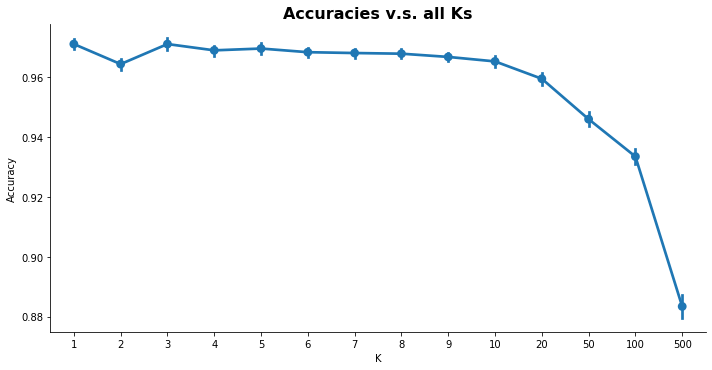

In [22]:
combined_accurancies = np.concatenate([Accuracies[:5], Accuracies2, Accuracies[5:]])
combined_Ks = np.concatenate([Ks[:5],  [6,7,8,9], Ks[5:]])

data = pd.DataFrame({'K': np.repeat(combined_Ks, 10), 'Accuracy': np.array(combined_accurancies).reshape(-1)})

sns.catplot(x='K', y='Accuracy',  kind="point", data=data, aspect=2)
plt.title('Accuracies v.s. all Ks', weight='bold', fontsize=16)
plt.show()

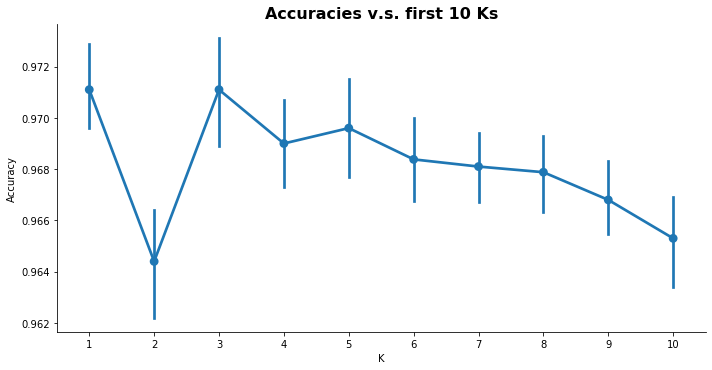

In [23]:
data = pd.DataFrame({'K': np.repeat(combined_Ks[:10], 10), 'Accuracy': np.array(combined_accurancies[:10]).reshape(-1)})

sns.catplot(x='K', y='Accuracy',  kind="point", data=data, aspect=2)
plt.title('Accuracies v.s. first 10 Ks', weight='bold', fontsize=16)
plt.show()

In [24]:
avg_accuracies = np.average(combined_accurancies, axis=1)
print(avg_accuracies)
best_k = np.argmax(avg_accuracies)+1
print(f"The optimal K is {best_k}")

[0.9711  0.9644  0.9711  0.969   0.9696  0.96838 0.9681  0.96788 0.9668
 0.9653  0.9595  0.946   0.9335  0.8834 ]
The optimal K is 1


## Notice that K=1 and K=3 achieved similar accurancies so we will test using both of them

### 1.1.4 KNN Testing

In [16]:
########################## Again, we won't execute this cell ##############################
%%perl -eat

best_k = 1
# best_k = 3

start_time = time.time()
score = kNNTrain(X_train, y_train, X_test, y_test, K=best_k)
elapsed_time = time.time() - start_time
print("k=%d, accuracy=%.2f%%, time=%.2f" % (k, score*100, elapsed_time))

UsageError: Line magic function `%%perl` not found.


In [3]:
# for k=1
!python kNNTest.py

k=1, accuracy=96.66%, time=785.04


In [1]:
# for k=3
!python kNNTest2.py

k=3, accuracy=96.81%, time=909.56


## 1.2 Compare Different Distance Metric

We will replace the original distance metrix with $\|X-X_0\|_p$ for $p=1,2,\cdots,10$.

In [16]:
########################## Similarly, this cell won't be excecuted either ##############################
%%perl -eat

best_k = 1
# best_k = 3

accuracies = []
for p in range(1, 11):
    accuracies = []

    start_time = time.time()
    model = KNeighborsClassifier(n_neighbors=best_k, p=p)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    elapsed_time = time.time() - start_time

    accuracies.append(score)
    print("p=%d, accuracy=%.2f%%, time=%.2f" % (p, score * 100, elapsed_time))

accuracies = np.array(accuracies)
np.savetxt("distance_results.csv", accuracies, delimiter=",")

UsageError: Line magic function `%%perl` not found.


In [2]:
# for k=1
!python kNNDistance.py

p=1, accuracy=95.99%, time=912.96
p=2, accuracy=96.66%, time=921.89
p=3, accuracy=96.98%, time=910.97
p=4, accuracy=97.07%, time=890.34
p=5, accuracy=97.15%, time=883.90
p=6, accuracy=97.15%, time=1005.85
p=7, accuracy=97.17%, time=947.32
p=8, accuracy=97.15%, time=898.36
p=9, accuracy=97.20%, time=1024.26
p=10, accuracy=97.17%, time=885.19


In [3]:
# for k=3
!python kNNDistance2.py

p=1, accuracy=96.02%, time=839.60
p=2, accuracy=96.81%, time=945.41
p=3, accuracy=97.06%, time=910.48
p=4, accuracy=97.20%, time=894.39
p=5, accuracy=97.26%, time=896.24
p=6, accuracy=97.26%, time=869.87
p=7, accuracy=97.24%, time=935.34
p=8, accuracy=97.34%, time=997.67
p=9, accuracy=97.32%, time=957.46
p=10, accuracy=97.24%, time=944.36
